In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import time
import datetime

import pickle

# Next two imports only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022

with open('data/model_scoring_dict.pickle', 'rb') as f:
    model_scoring_dict = pickle.load(f)

with open('data/models_dict.pickle', 'rb') as f:
    models_dict = pickle.load(f)

In [2]:
# Use this cell to reset the model dictionaries
#model_scoring_dict = {}
#models_dict = {}

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [3]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

X_test_comp = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

We'll first check to see if the classes are imbalanced.

In [4]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is not necessarily a huge problem, so we won't do anything about it right this second, but we may revisit the issue after we get a first rough model built.

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [6]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [239]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

## Preprocessing

In [240]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)

### Simple Imputer

In [241]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [242]:
X_train_obj = X_train_imp[obj_columns]
X_test_obj = X_test_imp[obj_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

In [243]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [13]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

log_reg_h1n1.fit(X_train_scaled, y_train_h1n1)
log_reg_ssnl.fit(X_train_scaled, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [14]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_scaled)
y_hat_ssnl = log_reg_ssnl.predict(X_test_scaled)

In [15]:
y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_scaled)

In [16]:
cf_matrix_h1n1 = confusion_matrix(y_test_h1n1, y_hat_h1n1)
cf_matrix_ssnl = confusion_matrix(y_test_ssnl, y_hat_ssnl)

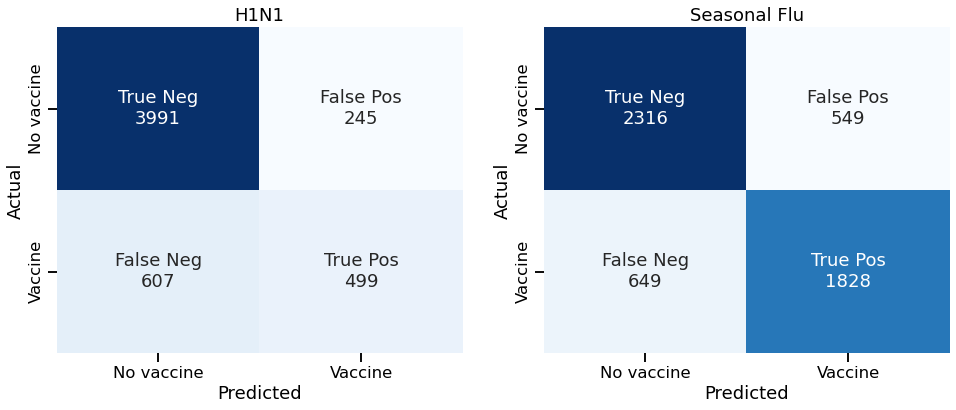

In [17]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['No vaccine', 'Vaccine']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix_h1n1.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

group_counts_2 = ['{0:0.0f}'.format(value) for value in cf_matrix_ssnl.flatten()]
labels_2 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_2)]
labels_2 = np.asarray(labels_2).reshape(2,2)

sns.set_context('talk')
fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

sns.heatmap(cf_matrix_h1n1, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax1)
ax1.set_ylabel('Actual')
ax1.set_yticklabels(ax1.get_yticklabels(), va="center")
ax1.set_xlabel('Predicted')
ax1.set_title('H1N1')

sns.heatmap(cf_matrix_ssnl, annot=labels_2, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax2)
ax2.set_ylabel('Actual')
ax2.set_yticklabels(ax2.get_yticklabels(), va="center")
ax2.set_xlabel('Predicted')
ax2.set_title('Seasonal Flu');

In [18]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl[:,1])}')

Recall for H1N1:            0.4511754068716094
Recall for seasonal flu:    0.7379895034315704

Precision for H1N1:         0.6706989247311828
Precision for seasonal flu: 0.769036600757257

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.775739423436915

F1 score for H1N1:          0.5394594594594594
F1 score for seasonal flu:  0.753193242686444

AUROC for H1N1:             0.8396438774168541
AUROC for seasonal flu:     0.8492191688842763


# Refactor into a pipeline

Now that we've got a basic and working but still fairly rough model with our cleaning steps mostly sorted out, we'll build a pipeline. We'll also code some of our graphing and scoring steps as a function so we can easily spit out several metrics for each model.

We'll also first redo our train-test split with with stratify because the H1N1-vaccinated class is slightly imbalanced. It likely won't be a drastic improvement, but we may be able to squeeze a small amount of extra juice out of any models going forward.

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)

In [226]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]

In [227]:
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()

In [228]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)
all_columns = list(X_train.columns.values)

### Two preprocessors, one for tree-based models, one for anything else

On closer inspection of the data, it's clear that the entire dataset is actually categorical. As such, our logistic regression would likely benefit from the whole dataset being one-hot encoded. On the other hand, tree-based models won't necessarily benefit from one-hot encoding, and a good deal of the categorical data is ordinal, which would benefit from scaling.

So one preprocessor will impute missing values and then one-hot encode every feature. The other processor will impute missing values, encode certain ordinal categories as numerical, and then min-max scale all ordinal features.

### The Common pipe

The pipelines can become somewhat complicated when attempting to run multiple imputers on different sets of columns. Because of this, we'll make a custom imputer function specifically for this dataframe before building the pipeline. This is all necessary because three of our columns have nearly half of their values missing. It seems not quite right to replace them with the mode or median (like we'll do with the rest of the columns), but we also certainly don't want to be dropping ten-thousand datapoints. So for those we'll impute their missing values by hand with 'unknown', or in the case of health_insuarance, which is binary, with 2 (which will act more or less like 'unknown'). 

We'll also ordinally encode certain columns by hand (age_group, education, and income_poverty) for similar reasons. 

In [23]:
def impute_unk(df):
    df.loc[df['employment_industry'].isna(), 'employment_industry'] = 'unknown'
    df.loc[df['employment_occupation'].isna(), 'employment_occupation'] = 'unknown'
    df.loc[df['health_insurance'].isna(), 'health_insurance'] = 2
    
    for column in df:
        if df[column].isnull().any():
            df[column]=df[column].fillna(df[column].mode()[0])

In [24]:
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [25]:
def clean(df):
    impute_unk(df)
    ord_encode(df)

### Pipelines made easy



In [26]:
def train_new_model(estimator, preprocessor, grid=None, model_name=['H1N1', 'Seasonal Flu'], keep_score=False, suppress_output=False):
    """
    This function takes in a tuned estimator as well as a choice of a preprocessor
    and returns a number of scoring metrics. It also saves the model and it's
    results in a scoring dictionary. It can alternatively do a grid search if passed
    a grid list. Scoring output can be suppressed with suppress_output=True.
    
    Note: The grid search feature is not yet functional.
    
    estimator: the class of the regressor or classifier to be modeled. Any desired
    hyperparameters should be included (e.g. LogisticRegression(max_iter=1000)).
    
    preprocessor: string - 'linear' or 'tree'
    
    grid: a list of hyperparameters with which do do a grid search
    
    suppress_output: bool
    """
    
    ohe_transform = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])
        
    linear_preprocessor = Pipeline(
        steps=[
            ('ohe', ohe_transform),
            ('est', estimator)
        ])
        
    tree_transformer = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), numeric_columns),
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
        ])
        
    tree_preprocessor = Pipeline(
        steps=[
            ('tree', tree_transformer),
            ('est', estimator)
        ])
    
    if grid:
        pass
    
    else:
        
        global y_hat_h1n1
        global y_proba_h1n1
        global y_proba_h1n1_comp
        global y_hat_ssnl
        global y_proba_ssnl
        global y_proba_ssnl_comp
        
        global models_dict
        
        if preprocessor == 'linear':
            pipe = linear_preprocessor
        elif preprocessor == 'tree':
            pipe = tree_preprocessor
        
        def create_entry(i):
            
            dictionary_entry = {'estimator': None, 
                                'preprocessor': None, 
                                'fitted_estimator': None, 
                                'scores': None,
                                'time_run': None
                               }
            
            dictionary_entry['estimator'] = estimator
            dictionary_entry['preprocessor'] = preprocessor
            dictionary_entry['fitted_estimator'] = fitted_estimator
            dictionary_entry['time_run'] = time.asctime()
            models_dict[model_name[i]] = dictionary_entry
        
        clean(X_train)
        clean(X_test)
        clean(X_test_comp)
        
        fitted_estimator = pipe.fit(X_train, y_train_h1n1)
        y_hat_h1n1 = pipe.predict(X_test)
        y_proba_h1n1 = pipe.predict_proba(X_test)
        y_proba_h1n1_comp = pipe.predict_proba(X_test_comp)
        
        if keep_score:
            create_entry(0)

        fitted_estimator = pipe.fit(X_train, y_train_ssnl)
        y_hat_ssnl = pipe.predict(X_test)
        y_proba_ssnl = pipe.predict_proba(X_test)
        y_proba_ssnl_comp = pipe.predict_proba(X_test_comp)
        
        if keep_score:
            create_entry(1)
            
        all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=model_name, keep_score=keep_score, suppress_output=suppress_output)

- hook up skylar slide to functions

### And a nice big function to score them

This function will take in lists of target data and lists of predictions and probabilities and return a number of scoring metrics as well as print out confusion matrices for quick and easy comprehension.

In [124]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False, suppress_output=False):
    """
    This function takes in y_data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    suppress_output, bool, if True, scores the model and can additionally
    save scores but does not output any graphs or scoring metrics
    
    Note: save_fig is only supported for single models.
    
    """
    global model_scoring_dict
    global models_dict

    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in list(range(len(y_actuals))):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                        
                        if model_name[i] not in models_dict:
                            models_dict[model_name[i]] = {}
                        
                        models_dict[model_name[i]]['scores'] = model_scoring_dict[model_name[i]]
            
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                    models_dict[model_name]['scores'] = model_scoring_dict[model_name]

            else:
                all_scores['model'] = model_scores
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

And one more little function to create a file for submission to the competition.

In [28]:
def competition_score_csv():
    
    now = datetime.datetime.now()

    date_time_string = str(now.month) + str(now.day) + str(now.year) + str(now.hour) + str(now.minute) + str(now.second)
    
    submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")
    
    if np.testing.assert_array_equal(X_test_comp.index.values, submission_df.index.values) == False:
        return
    
    submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
    submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]
    
    submission_df.to_csv(f'data/comp_submissions/my_submission{date_time_string}.csv', index=True)
    
    return submission_df.head()

In [48]:
models_dict.keys()

dict_keys(['Tuned SVC - H1N1', 'Tuned SVC - SSNL', 'Simple Logistic - H1N1', 'Simple Logistic - SSNL', 'Untuned SVC - H1N1', 'Untuned SVC - SSNL', 'Tuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - SSNL', 'Untuned HistGradientBoost - H1N1', 'Untuned HistGradientBoost - SSNL', 'Tuned Random Forest - H1N1', 'Tuned Random Forest - SSNL', 'Untuned Random Forest - H1N1', 'Untuned Random Forest - SSNL', 'Untuned Naive Bayes - H1N1', 'Untuned Naive Bayes - SSNL', 'Tuned Naive Bayes - H1N1', 'Tuned Naive Bayes - SSNL'])

# Keeping a model dictionary

So now that the pipeline and scoring code is done, we can start throwing models at it. The easiest way to keep things organized would be to build a function or a dictionary or both to run the models through the pipeline and keep the models afterwards

# Models galore!

Recall for Simple Logistic - H1N1:    0.5004405286343613
Recall for Simple Logistic - SSNL:    0.7442424242424243

Precision for Simple Logistic - H1N1: 0.7244897959183674
Precision for Simple Logistic - SSNL: 0.76814011676397

Accuracy for Simple Logistic - H1N1:  0.8534256832646949
Accuracy for Simple Logistic - SSNL:  0.7774241856982403

F1 score for Simple Logistic - H1N1:  0.5919749869723814
F1 score for Simple Logistic - SSNL:  0.7560024625487379

AUROC for Simple Logistic - H1N1:     0.8691042514625823
AUROC for Simple Logistic - SSNL:     0.8564199370756748
CPU times: user 6.8 s, sys: 1.85 s, total: 8.65 s
Wall time: 2.94 s


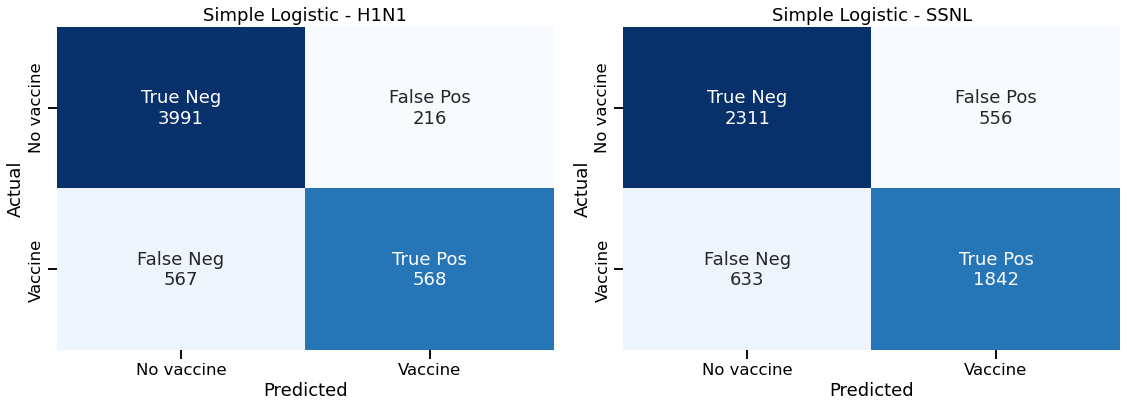

In [33]:
# First Logistic Regression

%%time
train_new_model(LogisticRegression(max_iter=1000), 'linear', keep_score=True, model_name=['Simple Logistic - H1N1', 'Simple Logistic - SSNL'])

Recall for Untuned Naive Bayes - H1N1:    0.7295154185022027
Recall for Untuned Naive Bayes - SSNL:    0.7684848484848484

Precision for Untuned Naive Bayes - H1N1: 0.37894736842105264
Precision for Untuned Naive Bayes - SSNL: 0.6583592938733126

Accuracy for Untuned Naive Bayes - H1N1:  0.6885061774616249
Accuracy for Untuned Naive Bayes - SSNL:  0.7079745413702733

F1 score for Untuned Naive Bayes - H1N1:  0.4987951807228916
F1 score for Untuned Naive Bayes - SSNL:  0.70917225950783

AUROC for Untuned Naive Bayes - H1N1:     0.7618796656296565
AUROC for Untuned Naive Bayes - SSNL:     0.7826719937427994


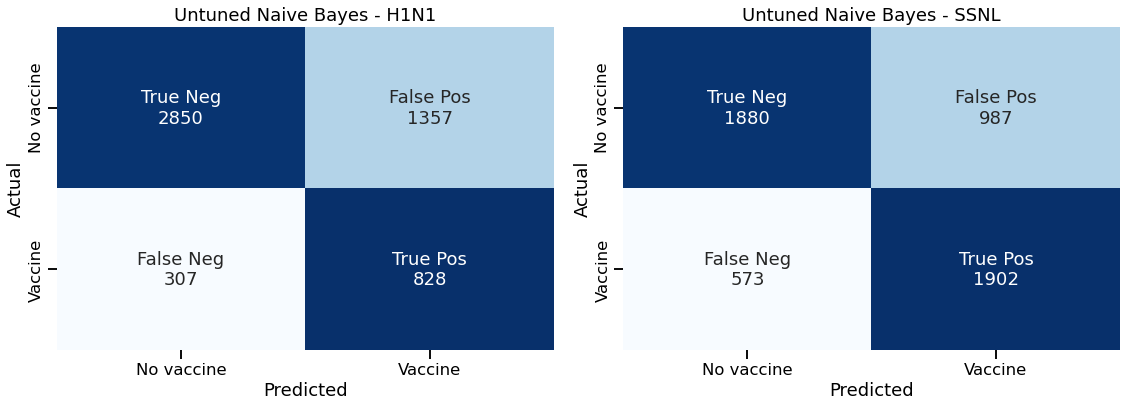

In [45]:
# Worst Naive Bayes

train_new_model(GaussianNB(), 'linear', model_name=['Untuned Naive Bayes - H1N1', 'Untuned Naive Bayes - SSNL'], keep_score=True)

Recall for Tuned Naive Bayes - H1N1:    0.5744493392070484
Recall for Tuned Naive Bayes - SSNL:    0.7915151515151515

Precision for Tuned Naive Bayes - H1N1: 0.57243195785777
Precision for Tuned Naive Bayes - SSNL: 0.6941885187810064

Accuracy for Tuned Naive Bayes - H1N1:  0.8184200673904904
Accuracy for Tuned Naive Bayes - SSNL:  0.7418569824035942

F1 score for Tuned Naive Bayes - H1N1:  0.5734388742304309
F1 score for Tuned Naive Bayes - SSNL:  0.7396639607324902

AUROC for Tuned Naive Bayes - H1N1:     0.8285115325935691
AUROC for Tuned Naive Bayes - SSNL:     0.82314445466172


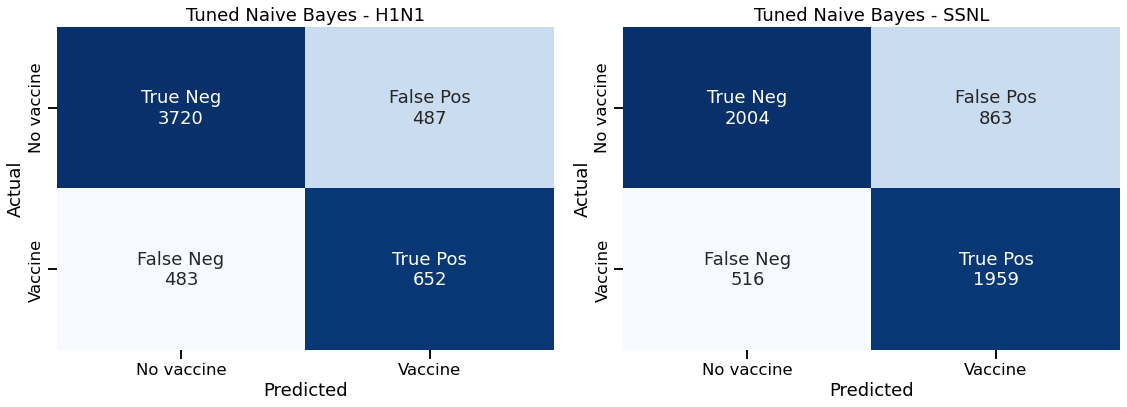

In [47]:
# Best Naive Bayes

train_new_model(GaussianNB(var_smoothing=1), 'linear', model_name=['Tuned Naive Bayes - H1N1', 'Tuned Naive Bayes - SSNL'], keep_score=True)

Recall for Untuned SVC - H1N1:    0.45374449339207046
Recall for Untuned SVC - SSNL:    0.7450505050505051

Precision for Untuned SVC - H1N1: 0.7756024096385542
Precision for Untuned SVC - SSNL: 0.7689741451209341

Accuracy for Untuned SVC - H1N1:  0.8560464245600898
Accuracy for Untuned SVC - SSNL:  0.778172968925496

F1 score for Untuned SVC - H1N1:  0.5725403001667593
F1 score for Untuned SVC - SSNL:  0.7568233121280525

AUROC for Untuned SVC - H1N1:     0.8602324215252741
AUROC for Untuned SVC - SSNL:     0.8547669228031977


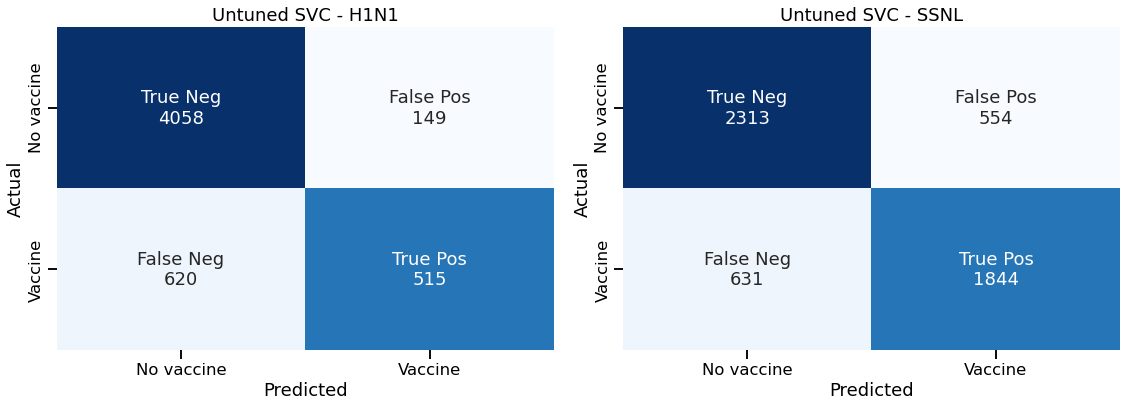

In [34]:
# Worst SVC

train_new_model(SVC(probability=True), 'linear', model_name=['Untuned SVC - H1N1', 'Untuned SVC - SSNL'], keep_score=True)

Recall for Tuned HistGradientBoost - H1N1:    0.5101321585903084
Recall for Tuned HistGradientBoost - SSNL:    0.7575757575757576

Precision for Tuned HistGradientBoost - H1N1: 0.7394636015325671
Precision for Tuned HistGradientBoost - SSNL: 0.7649938800489596

Accuracy for Tuned HistGradientBoost - H1N1:  0.8577311868214152
Accuracy for Tuned HistGradientBoost - SSNL:  0.7798577311868214

F1 score for Tuned HistGradientBoost - H1N1:  0.6037539103232533
F1 score for Tuned HistGradientBoost - SSNL:  0.761266747868453

AUROC for Tuned HistGradientBoost - H1N1:     0.8727243978726456
AUROC for Tuned HistGradientBoost - SSNL:     0.8585395637575617


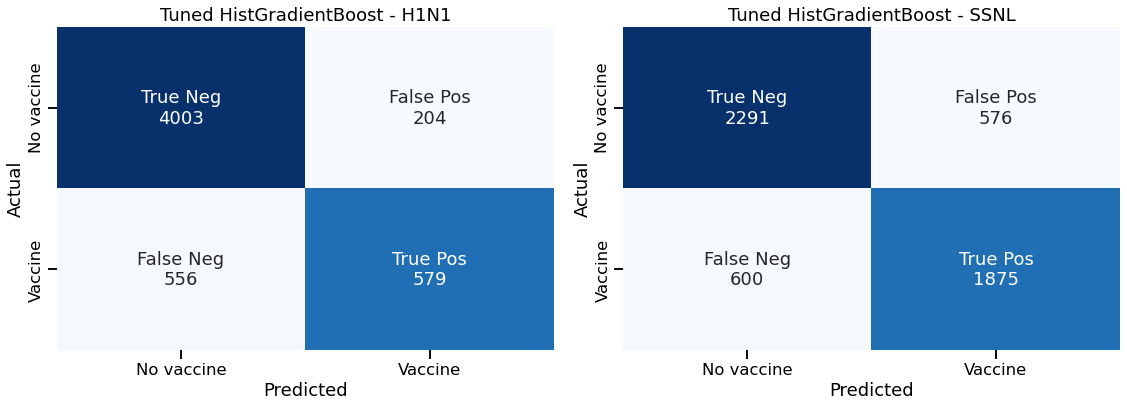

In [35]:
# Best HistGradientBoosting

train_new_model(HistGradientBoostingClassifier(learning_rate=0.1, max_depth=9, max_iter=70), 'tree', model_name=['Tuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - SSNL'], keep_score=True)

In [142]:
(0.8740639944543862 + 0.8572953814390856) / 2

0.8656796879467359

In [144]:
(0.8735216845429634 + 0.8582966744529352) / 2

0.8659091794979493

Recall for Untuned HistGradientBoost - H1N1:    0.5145374449339207
Recall for Untuned HistGradientBoost - SSNL:    0.7575757575757576

Precision for Untuned HistGradientBoost - H1N1: 0.7364438839848676
Precision for Untuned HistGradientBoost - SSNL: 0.7665576451349142

Accuracy for Untuned HistGradientBoost - H1N1:  0.8577311868214152
Accuracy for Untuned HistGradientBoost - SSNL:  0.7807937102208911

F1 score for Untuned HistGradientBoost - H1N1:  0.6058091286307055
F1 score for Untuned HistGradientBoost - SSNL:  0.7620402357244461

AUROC for Untuned HistGradientBoost - H1N1:     0.87241800690898
AUROC for Untuned HistGradientBoost - SSNL:     0.8593248847033291


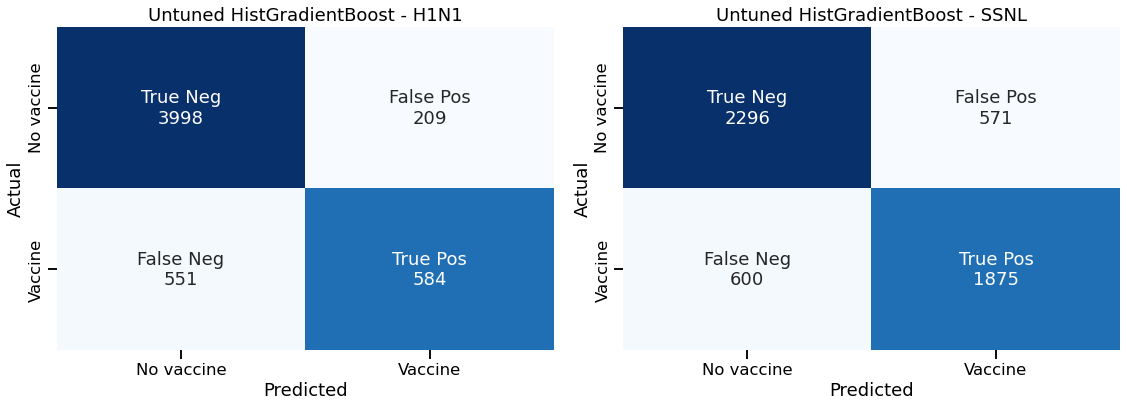

In [38]:
# Worst HistGradientBoost

train_new_model(HistGradientBoostingClassifier(), 'tree', model_name=['Untuned HistGradientBoost - H1N1', 'Untuned HistGradientBoost - SSNL'], keep_score=True)

# SOMETHING'S WRONG HERE

In [256]:
tuned_rf = models_dict['Tuned Random Forest - H1N1']['fitted_estimator']

In [257]:
y_hat_ssnl = tuned_rf.predict(X_test_clean)
y_proba_ssnl = tuned_rf.predict_proba(X_test_clean)

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['health_insurance'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

Recall:    0.8798732943469786
Precision: 0.9011729473421513
Accuracy:  0.8991377354209212
F1 score:  0.8903957588460115
AUROC:     0.9619289140520564


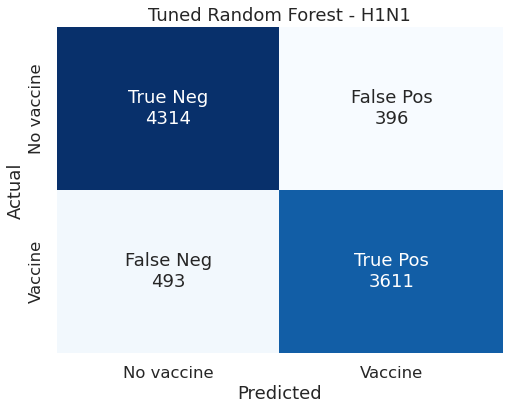

In [223]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name='Tuned Random Forest - H1N1', save_fig=True)

Recall for Untuned Random Forest - H1N1:    0.4211453744493392
Recall for Untuned Random Forest - SSNL:    0.7377777777777778

Precision for Untuned Random Forest - H1N1: 0.7709677419354839
Precision for Untuned Random Forest - SSNL: 0.7627401837928154

Accuracy for Untuned Random Forest - H1N1:  0.850430550355672
Accuracy for Untuned Random Forest - SSNL:  0.7721827031074504

F1 score for Untuned Random Forest - H1N1:  0.5447293447293448
F1 score for Untuned Random Forest - SSNL:  0.7500513452454303

AUROC for Untuned Random Forest - H1N1:     0.8605172415598504
AUROC for Untuned Random Forest - SSNL:     0.8484570152166944


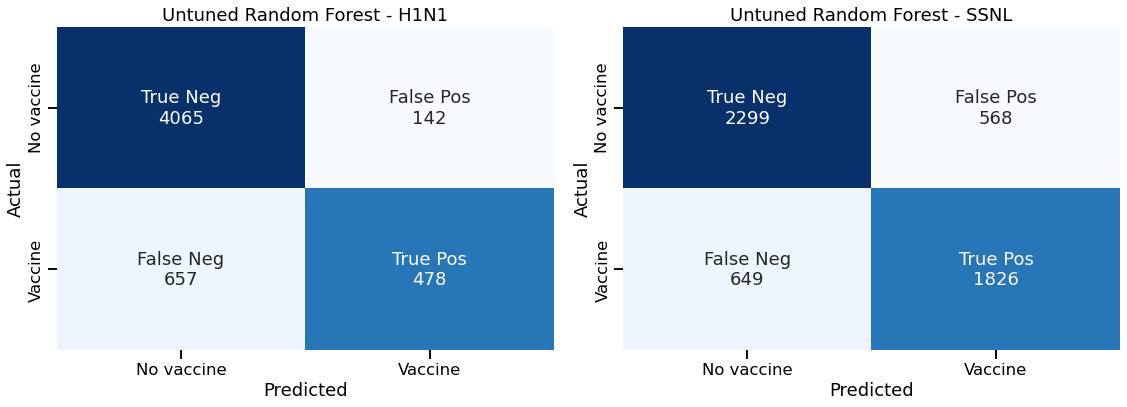

In [40]:
#Worst Forest

train_new_model(RandomForestClassifier(), 'tree', model_name=['Untuned Random Forest - H1N1', 'Untuned Random Forest - SSNL'], keep_score=True)

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Recall for Tuned Random Forest - H1N1:    0.42895299145299143
Recall for Tuned Random Forest - SSNL:    0.7492690058479532

Precision for Tuned Random Forest - H1N1: 0.7919132149901381
Precision for Tuned Random Forest - SSNL: 0.7763191113355213

Accuracy for Tuned Random Forest - H1N1:  0.8547764919446336
Accuracy for Tuned Random Forest - SSNL:  0.7827320172452916

F1 score for Tuned Random Forest - H1N1:  0.5564795564795565
F1 score for Tuned Random Forest - SSNL:  0.7625542467451953

AUROC for Tuned Random Forest - H1N1:     0.8579632338275381
AUROC for Tuned Random Forest - SSNL:     0.8575485363562244


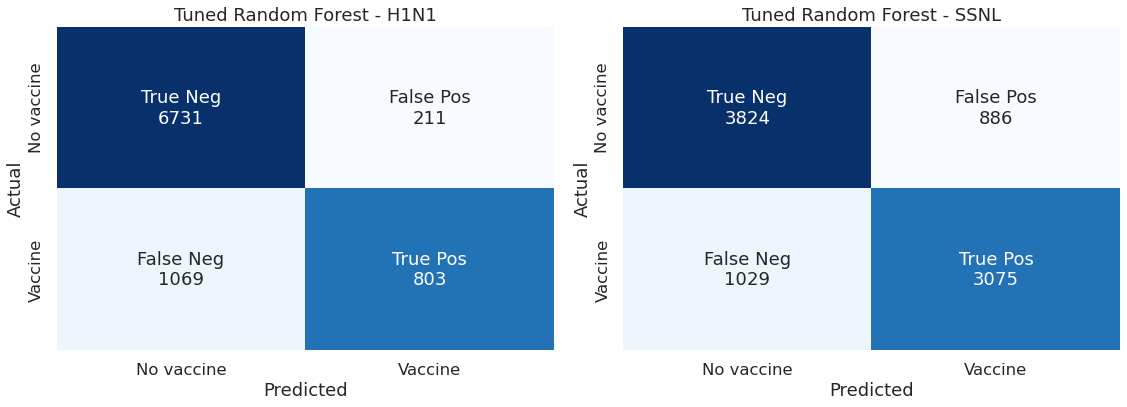

In [224]:
#Best Forest

train_new_model(RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=2, min_samples_split=4), 'tree', model_name=['Tuned Random Forest - H1N1', 'Tuned Random Forest - SSNL'], keep_score=True)

In [275]:
model_stack = [
    models_dict['Simple Logistic - H1N1']['fitted_estimator'],
    models_dict['Tuned HistGradientBoost - H1N1']['fitted_estimator'],
    models_dict['Tuned Random Forest - H1N1']['fitted_estimator']
]




In [218]:
for model in models_dict:
    print(model)    
    print(models_dict[model]['scores']['AUC'])



Simple Logistic - H1N1
0.8564199370756748
Simple Logistic - SSNL
0.8564199370756748
Tuned HistGradientBoost - H1N1
0.8595283846487195
Tuned HistGradientBoost - SSNL
0.8595283846487195
Simple Random Forest - H1N1
0.851203630303735
Tuned Random Forest - SSNL
0.851203630303735


{'Simple Logistic - H1N1': {'estimator': LogisticRegression(max_iter=1000),
  'preprocessor': 'linear',
  'fitted_estimator': Pipeline(steps=[('ohe',
                   ColumnTransformer(transformers=[('ohe',
                                                    OneHotEncoder(handle_unknown='ignore',
                                                                  sparse=False),
                                                    ['h1n1_concern',
                                                     'h1n1_knowledge',
                                                     'behavioral_antiviral_meds',
                                                     'behavioral_avoidance',
                                                     'behavioral_face_mask',
                                                     'behavioral_wash_hands',
                                                     'behavioral_large_gatherings',
                                                     'behavioral_outside_home',
 

In [204]:
model_scoring_dict

{'jambo': {'recall': 0.5004405286343613,
  'precision': 0.7244897959183674,
  'accuracy': 0.8534256832646949,
  'f1': 0.5919749869723814,
  'AUC': 0.8691042514625823},
 'warmbo': {'recall': 0.7442424242424243,
  'precision': 0.76814011676397,
  'accuracy': 0.7774241856982403,
  'f1': 0.7560024625487379,
  'AUC': 0.8564199370756748},
 'H1N1': {'recall': 0.4167400881057269,
  'precision': 0.7691056910569106,
  'accuracy': 0.8494945713216024,
  'f1': 0.5405714285714285,
  'AUC': 0.8631414602681288},
 'Seasonal Flu': {'recall': 0.7377777777777778,
  'precision': 0.7659395973154363,
  'accuracy': 0.7740546611755896,
  'f1': 0.7515949783906153,
  'AUC': 0.850227281535269},
 'Simple Logistic - H1N1': {'recall': 0.5004405286343613,
  'precision': 0.7244897959183674,
  'accuracy': 0.8534256832646949,
  'f1': 0.5919749869723814,
  'AUC': 0.8691042514625823},
 'Simple Logistic - SSNL': {'recall': 0.7442424242424243,
  'precision': 0.76814011676397,
  'accuracy': 0.7774241856982403,
  'f1': 0.7560

In [294]:
log_reg_h1n1 = StackingClassifier(model_stack)
log_reg_ssnl = StackingClassifier(model_stack)

log_reg_h1n1.fit(X_train_clean, y_train_h1n1)
log_reg_ssnl.fit(X_train_clean, y_train_ssnl);

TypeError: argument of type 'ColumnTransformer' is not iterable

### Now we'll score it and plot a confusion matrix

In [61]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_ohe)
y_hat_ssnl = log_reg_ssnl.predict(X_test_ohe)


y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_ohe)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_ohe)

Recall for H1N1:    0.43083700440528633
Recall for Seasonal Flu:    0.7470707070707071

Precision for H1N1: 0.6735537190082644
Precision for Seasonal Flu: 0.7707378074197583

Accuracy for H1N1:  0.8347061025833021
Accuracy for Seasonal Flu:  0.7798577311868214

F1 score for H1N1:  0.5255239118753358
F1 score for Seasonal Flu:  0.7587197373820271

AUROC for H1N1:     0.8400664300845351
AUROC for Seasonal Flu:     0.8549372342187131


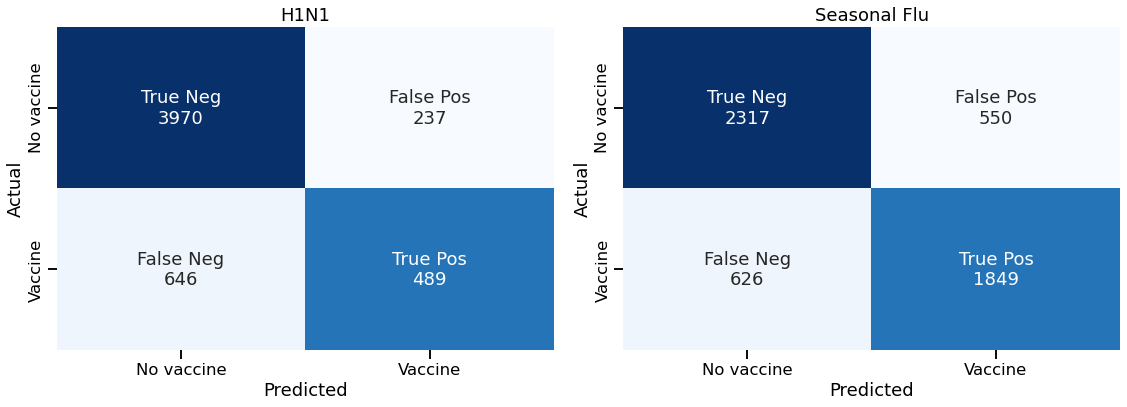

In [62]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])

In [276]:
# 1st model stacking attempt

train_new_model(StackingClassifier(model_stack), 'linear')

TypeError: argument of type 'ColumnTransformer' is not iterable

Recall for Tuned SVC - H1N1:    0.4801762114537445
Recall for Tuned SVC - SSNL:    0.7442424242424243

Precision for Tuned SVC - H1N1: 0.7384823848238482
Precision for Tuned SVC - SSNL: 0.7723270440251573

Accuracy for Tuned SVC - H1N1:  0.8534256832646949
Accuracy for Tuned SVC - SSNL:  0.7798577311868214

F1 score for Tuned SVC - H1N1:  0.5819540843566471
F1 score for Tuned SVC - SSNL:  0.7580246913580246

AUROC for Tuned SVC - H1N1:     0.8664405558598057
AUROC for Tuned SVC - SSNL:     0.8557746280383184


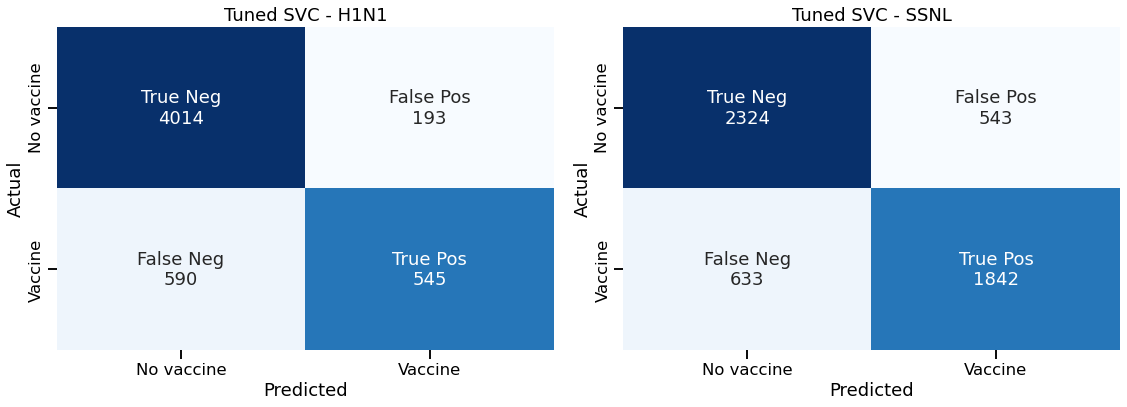

In [31]:
# Best SVC

train_new_model(SVC(probability = True, kernel='linear', C=1, gamma=0.001), 'linear', model_name=['Tuned SVC - H1N1', 'Tuned SVC - SSNL'], keep_score=True)

{'estimator': SVC(C=1, gamma=0.001, kernel='linear', probability=True),
 'preprocessor': 'linear',
 'fitted_estimator': Pipeline(steps=[('ohe',
                  ColumnTransformer(transformers=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False),
                                                   ['h1n1_concern',
                                                    'h1n1_knowledge',
                                                    'behavioral_antiviral_meds',
                                                    'behavioral_avoidance',
                                                    'behavioral_face_mask',
                                                    'behavioral_wash_hands',
                                                    'behavioral_large_gatherings',
                                                    'behavioral_outside_home',
                  

# SOMETHING'S WRONG HERE

In [229]:
tuned_svc = models_dict['Tuned SVC - SSNL']['fitted_estimator']

In [230]:
y_hat_ssnl = tuned_svc.predict(X_test)
y_proba_ssnl = tuned_svc.predict_proba(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Recall:    0.7592592592592593
Precision: 0.7844914400805639
Accuracy:  0.7907873837077377
F1 score:  0.7716691431401684
AUROC:     0.8647390252583571


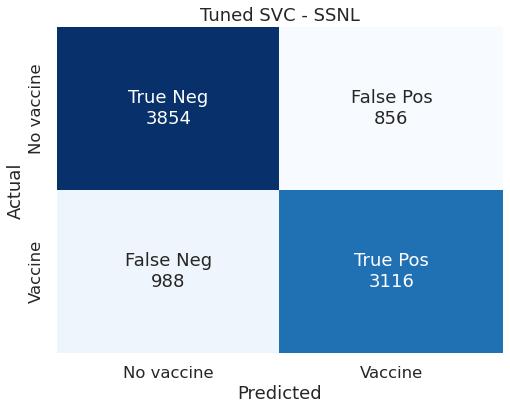

In [216]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name='Tuned SVC - SSNL', save_fig=True)

In [ ]:
all_metrics()

In [220]:
len(X_train)

17893

# Trying out a few models to diagnose any preprocessing issues

### Preprocessing for Tree-based models (though, at the end, I do run a logistic model below, just because I had it ready to go)

In [247]:
ord_num_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
ord_obj_columns = ['age_group', 'education', 'income_poverty']
cat_only_columns = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation', 'health_insurance']

In [248]:
for column in ord_obj_columns:
    print(X[column].value_counts())

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64
<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64


In [249]:
def ord_obj_as_num(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as numerical, according to a pre-defined
    list of values. This operation is in place.
    """

    age_group = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group, 'education': education, 'income_poverty': income_poverty}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [250]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [251]:
ord_obj_as_num(X_train_imp)
ord_obj_as_num(X_test_imp)

### minmax

In [252]:
X_train_num = X_train_imp.drop(cat_only_columns, axis=1)
X_test_num = X_test_imp.drop(cat_only_columns, axis=1)

In [253]:
minmax = MinMaxScaler()

X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_scaled = pd.DataFrame(minmax.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

In [254]:
X_train_obj = X_train_imp[cat_only_columns]
X_test_obj = X_test_imp[cat_only_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

In [255]:
X_train_clean = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test_clean = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [245]:
log_reg_h1n1 = LogisticRegression(max_iter=1000)
log_reg_ssnl = LogisticRegression(max_iter=1000)

log_reg_h1n1.fit(X_train_clean, y_train_h1n1)
log_reg_ssnl.fit(X_train_clean, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [246]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_clean)
y_hat_ssnl = log_reg_ssnl.predict(X_test_clean)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_clean)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_clean)

Recall for H1N1:    0.42555066079295156
Recall for Seasonal Flu:    0.7422222222222222

Precision for H1N1: 0.6764705882352942
Precision for Seasonal Flu: 0.7673350041771094

Accuracy for H1N1:  0.8347061025833021
Accuracy for Seasonal Flu:  0.7763010108573568

F1 score for H1N1:  0.5224445646295295
F1 score for Seasonal Flu:  0.7545697268432942

AUROC for H1N1:     0.8379208556328921
AUROC for Seasonal Flu:     0.8502034647134054


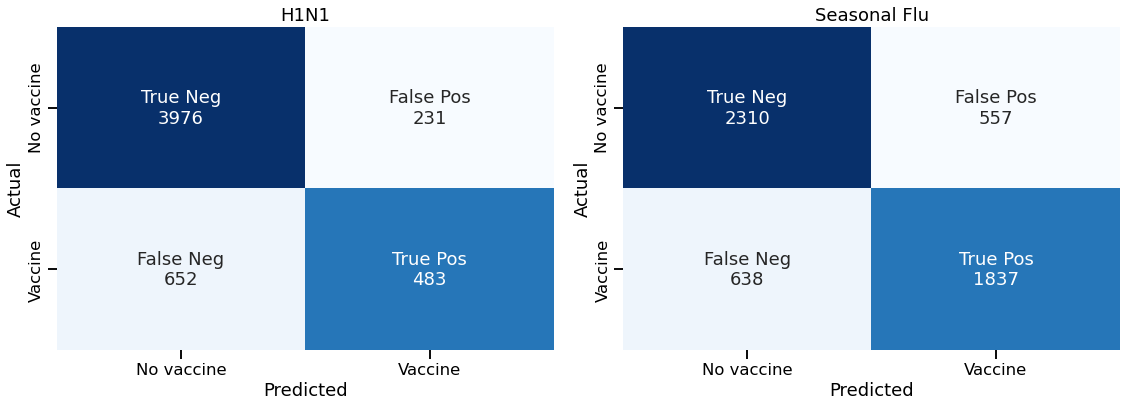

In [248]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])

# Logistic Regression, no tuning, dataset is fully OHE

### Simple Imputer

In [58]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [59]:
X_train_obj = X_train_imp
X_test_obj = X_test_imp

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [60]:
log_reg_h1n1 = LogisticRegression(max_iter=1000)
log_reg_ssnl = LogisticRegression(max_iter=1000)

log_reg_h1n1.fit(X_train_ohe, y_train_h1n1)
log_reg_ssnl.fit(X_train_ohe, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [61]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_ohe)
y_hat_ssnl = log_reg_ssnl.predict(X_test_ohe)


y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_ohe)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_ohe)

Recall for H1N1:    0.43083700440528633
Recall for Seasonal Flu:    0.7470707070707071

Precision for H1N1: 0.6735537190082644
Precision for Seasonal Flu: 0.7707378074197583

Accuracy for H1N1:  0.8347061025833021
Accuracy for Seasonal Flu:  0.7798577311868214

F1 score for H1N1:  0.5255239118753358
F1 score for Seasonal Flu:  0.7587197373820271

AUROC for H1N1:     0.8400664300845351
AUROC for Seasonal Flu:     0.8549372342187131


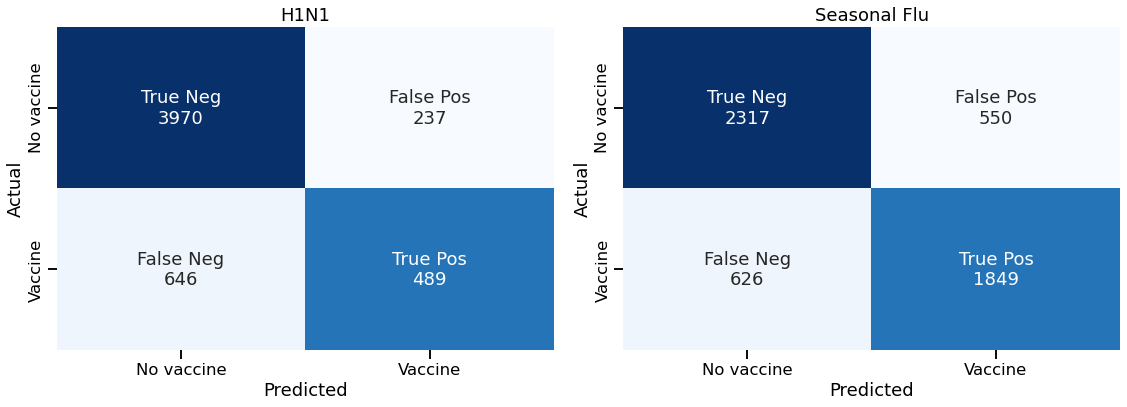

In [62]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['H1N1','Seasonal Flu'])

### Submitting this score to the competition, to guage our low-performing models

In [63]:
submission_df = pd.read_csv('data/submission_format.csv', 
                            index_col="respondent_id")

In [69]:
np.testing.assert_array_equal(X_test_comp.index.values, 
                              submission_df.index.values)

In [71]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_test_imp_comp = pd.DataFrame(imputer.transform(X_test_comp), columns=X_test_comp.columns, index=X_test_comp.index)

In [73]:
X_test_obj_comp = X_test_imp_comp

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_test_ohe_comp = pd.DataFrame(ohe.fit_transform(X_test_obj_comp), columns=ohe.get_feature_names(), index=X_test_obj_comp.index)

X_test_ohe_comp = pd.concat([X_test_imp_comp[numeric_columns], X_test_ohe_comp], axis=1)

In [75]:
y_proba_h1n1_comp = log_reg_h1n1.predict_proba(X_test_ohe_comp)
y_proba_ssnl_comp = log_reg_ssnl.predict_proba(X_test_ohe_comp)

In [76]:
submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.063167,0.318644
26708,0.037067,0.031498
26709,0.396263,0.732449
26710,0.447803,0.846152
26711,0.206356,0.337308


In [77]:
submission_df.to_csv('data/my_submission.csv', index=True)

In [79]:
!head data/my_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.06316673777509094,0.318644409195383
26708,0.0370669600357851,0.031498393319783935
26709,0.3962627864645949,0.7324491781802666
26710,0.44780272545585964,0.8461520789716166
26711,0.20635633316102836,0.33730823058077625
26712,0.4879251639827327,0.9455146388294033
26713,0.40716808436658614,0.5698070576015274
26714,0.10365816878055854,0.18773172753498987
26715,0.05173101047121089,0.16419234936578309


### One more model - just numeric columns - competition baseline

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=random_state)

In [113]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [114]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)

In [115]:
X_train_reduced = X_train[numeric_columns]
X_test_reduced = X_test[numeric_columns]

In [116]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_reduced), columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_reduced), columns=X_test_reduced.columns, index=X_test_reduced.index)

In [117]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train_reduced)

X_train_imp = pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test_scaled), columns=X_test_scaled.columns, index=X_test_scaled.index)

In [118]:
%%time

log_reg_h1n1 = LogisticRegression(penalty="l2", C=1)
log_reg_ssnl = LogisticRegression(penalty="l2", C=1)

log_reg_h1n1.fit(X_train_imp, y_train_h1n1)
log_reg_ssnl.fit(X_train_imp, y_train_ssnl);

CPU times: user 110 ms, sys: 55.6 ms, total: 165 ms
Wall time: 73.9 ms


LogisticRegression(C=1)

### Now we'll score it and plot a confusion matrix

In [119]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_imp)
y_hat_ssnl = log_reg_ssnl.predict(X_test_imp)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_imp)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_imp)

Recall for Competition Baseline - H1N1:    0.4043803418803419
Recall for Competition Baseline - Seasonal Flu:    0.7151559454191033

Precision for Competition Baseline - H1N1: 0.6503436426116839
Precision for Competition Baseline - Seasonal Flu: 0.7458703939008895

Accuracy for Competition Baseline - H1N1:  0.8273201724529158
Accuracy for Competition Baseline - Seasonal Flu:  0.7539142273655548

F1 score for Competition Baseline - H1N1:  0.49868247694334655
F1 score for Competition Baseline - Seasonal Flu:  0.7301903221793755

AUROC for Competition Baseline - H1N1:     0.8206886901112268
AUROC for Competition Baseline - Seasonal Flu:     0.8223370964270786


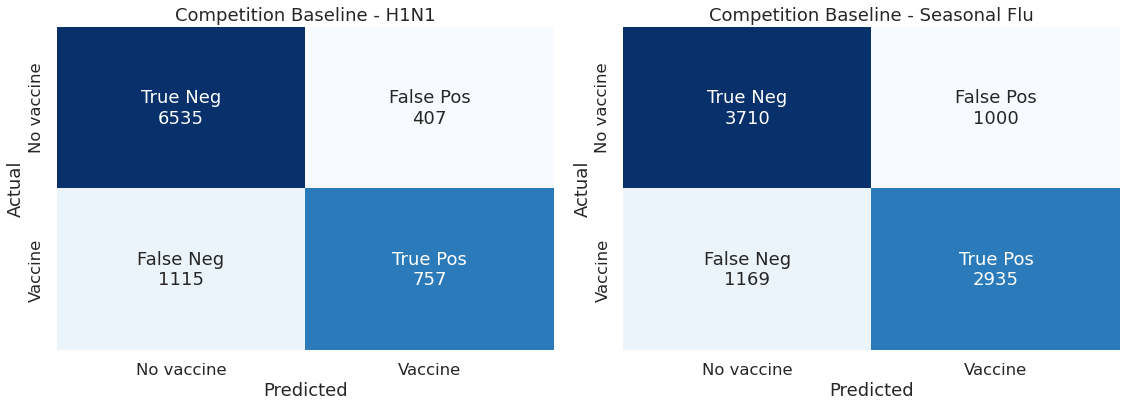

In [125]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['Competition Baseline - H1N1','Competition Baseline - Seasonal Flu'], keep_score=True)

# First models after getting pipeline working

### Untuned Logistic Regression

In [383]:
linear_preprocessor.fit(X_train, y_train_h1n1)
y_hat_h1n1 = linear_preprocessor.predict(X_test)
y_proba_h1n1 = linear_preprocessor.predict_proba(X_test)
y_proba_h1n1_comp = linear_preprocessor.predict_proba(X_test_comp)

linear_preprocessor.fit(X_train, y_train_ssnl)
y_hat_ssnl = linear_preprocessor.predict(X_test)
y_proba_ssnl = linear_preprocessor.predict_proba(X_test)
y_proba_ssnl_comp = linear_preprocessor.predict_proba(X_test_comp)

Recall for H1N1:    0.5004405286343613
Recall for Seasonal Flu:    0.7442424242424243

Precision for H1N1: 0.7244897959183674
Precision for Seasonal Flu: 0.76814011676397

Accuracy for H1N1:  0.8534256832646949
Accuracy for Seasonal Flu:  0.7774241856982403

F1 score for H1N1:  0.5919749869723814
F1 score for Seasonal Flu:  0.7560024625487379

AUROC for H1N1:     0.8691042514625823
AUROC for Seasonal Flu:     0.8564199370756748


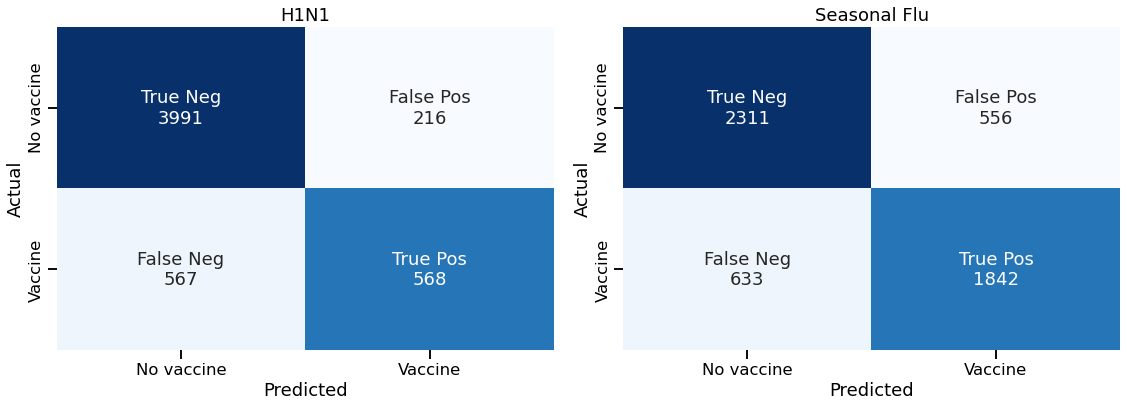

In [384]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], ['H1N1', 'Seasonal Flu'])

In [258]:
(0.8691092776984864+0.8564203598594949) / 2

0.8627648187789907

In [252]:
submission_df = pd.read_csv('data/submission_format.csv', 
                            index_col="respondent_id")

In [253]:
np.testing.assert_array_equal(X_test_comp.index.values, 
                              submission_df.index.values)

In [254]:
submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.113173,0.375069
26708,0.025997,0.028402
26709,0.244246,0.695510
26710,0.500280,0.859745
26711,0.322239,0.403610


In [255]:
submission_df.to_csv('data/my_submission.csv', index=True)

In [256]:
!head data/my_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.11317282884027721,0.37506939114042215
26708,0.02599737885236411,0.028402248436015777
26709,0.2442462051065385,0.6955101258538736
26710,0.5002803932105893,0.859745437477238
26711,0.3222389143238363,0.4036097227087465
26712,0.6852679617965983,0.9589032310334851
26713,0.19983915048877718,0.4959990653500269
26714,0.17226834641640074,0.2301630679050126
26715,0.01923289882731021,0.13394514386092657


### Randomly Tuned Random Forest

In [381]:
tree_preprocessor.fit(X_train, y_train_h1n1)
y_hat_h1n1 = tree_preprocessor.predict(X_test)
y_proba_h1n1 = tree_preprocessor.predict_proba(X_test)
y_proba_h1n1_comp = tree_preprocessor.predict_proba(X_test_comp)

tree_preprocessor.fit(X_train, y_train_ssnl)
y_hat_ssnl = tree_preprocessor.predict(X_test)
y_proba_ssnl = tree_preprocessor.predict_proba(X_test)
y_proba_ssnl_comp = tree_preprocessor.predict_proba(X_test_comp)

Recall for H1N1:    0.39118942731277534
Recall for Seasonal Flu:    0.7442424242424243

Precision for H1N1: 0.7775831873905429
Precision for Seasonal Flu: 0.7691022964509394

Accuracy for H1N1:  0.8468738300262074
Accuracy for Seasonal Flu:  0.7779857731186821

F1 score for H1N1:  0.5205158264947245
F1 score for Seasonal Flu:  0.7564681724845996

AUROC for H1N1:     0.8673921898576842
AUROC for Seasonal Flu:     0.8528471319402605


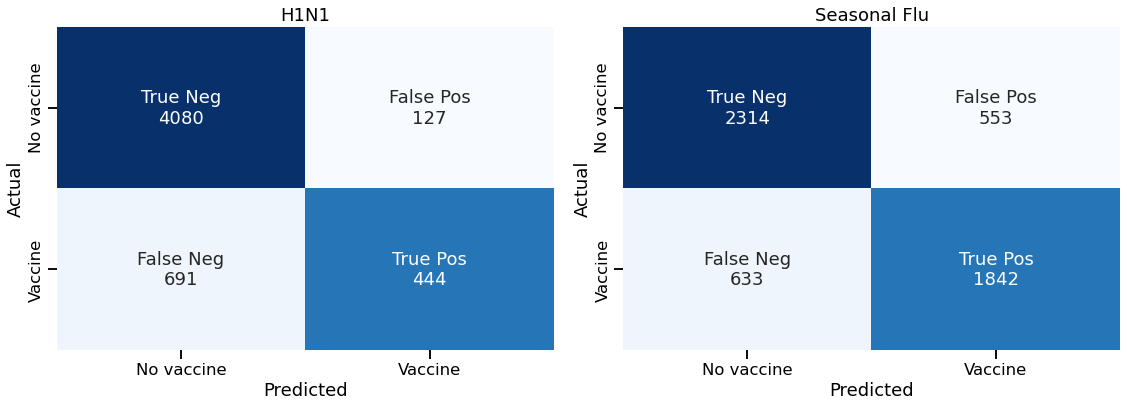

In [382]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], ['H1N1', 'Seasonal Flu'])

In [209]:
clean(X_train)
clean(X_test)
clean(X_test_comp)

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-23-3643085ead20>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column]=df[column].fillna(df[column].mode()[0])


### The Linear preprocessor

In [25]:
ohe_transform = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])

In [26]:
linear_preprocessor = Pipeline(
    steps=[
        ('ohe', ohe_transform),
        ('est', est)
    ])

NameError: name 'est' is not defined

### The Tree preprocessor

In [83]:
tree_transformer = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), numeric_columns),
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
    ])

In [84]:
tree_preprocessor = Pipeline(
    steps=[
        ('tree', tree_transformer),
        ('est', est)
    ])

# THE SLIDE

In [126]:
models_to_graph = list(models_dict.keys())

In [181]:
models_dict['Tuned Random Forest - H1N1']

{'estimator': RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4),
 'preprocessor': 'tree',
 'fitted_estimator': Pipeline(steps=[('tree',
                  ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                   ['h1n1_concern',
                                                    'h1n1_knowledge',
                                                    'behavioral_antiviral_meds',
                                                    'behavioral_avoidance',
                                                    'behavioral_face_mask',
                                                    'behavioral_wash_hands',
                                                    'behavioral_large_gatherings',
                                                    'behavioral_outside_home',
                                                    'behavioral_touch_face',
                                                    'doctor_recc_h1n1',


In [141]:
h1n1_models_to_graph = ['Competition Baseline - H1N1', 'Untuned Naive Bayes - H1N1', 'Tuned Naive Bayes - H1N1', 'Simple Logistic - H1N1', 'Untuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - H1N1', 'Untuned Random Forest - H1N1', 'Tuned Random Forest - H1N1', 'Untuned SVC - H1N1', 'Tuned SVC - H1N1']
ssnl_models_to_graph = ['Competition Baseline - Seasonal Flu', 'Untuned Naive Bayes - SSNL', 'Tuned Naive Bayes - SSNL', 'Simple Logistic - SSNL', 'Untuned HistGradientBoost - SSNL', 'Tuned HistGradientBoost - SSNL', 'Untuned Random Forest - SSNL', 'Tuned Random Forest - SSNL', 'Untuned SVC - SSNL', 'Tuned SVC - SSNL',]

In [202]:
h1n1_graph_data = []

for model in h1n1_models_to_graph:
    h1n1_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))
    
ssnl_graph_data = []

for model in ssnl_models_to_graph:
    ssnl_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))

In [203]:
ssnl_graph_data

[('Competition Baseline - Seasonal Flu',
  0.7458703939008895,
  0.7539142273655548),
 ('Untuned Naive Bayes - SSNL', 0.6583592938733126, 0.7079745413702733),
 ('Tuned Naive Bayes - SSNL', 0.6941885187810064, 0.7418569824035942),
 ('Simple Logistic - SSNL', 0.76814011676397, 0.7774241856982403),
 ('Untuned HistGradientBoost - SSNL', 0.7665576451349142, 0.7807937102208911),
 ('Tuned HistGradientBoost - SSNL', 0.7649938800489596, 0.7798577311868214),
 ('Untuned Random Forest - SSNL', 0.7627401837928154, 0.7721827031074504),
 ('Tuned Random Forest - SSNL', 0.7694560669456066, 0.7777985773118682),
 ('Untuned SVC - SSNL', 0.7689741451209341, 0.778172968925496),
 ('Tuned SVC - SSNL', 0.7723270440251573, 0.7798577311868214)]

In [204]:
h1n1_graph_data

[('Competition Baseline - H1N1', 0.6503436426116839, 0.8273201724529158),
 ('Untuned Naive Bayes - H1N1', 0.37894736842105264, 0.6885061774616249),
 ('Tuned Naive Bayes - H1N1', 0.57243195785777, 0.8184200673904904),
 ('Simple Logistic - H1N1', 0.7244897959183674, 0.8534256832646949),
 ('Untuned HistGradientBoost - H1N1', 0.7364438839848676, 0.8577311868214152),
 ('Tuned HistGradientBoost - H1N1', 0.7394636015325671, 0.8577311868214152),
 ('Untuned Random Forest - H1N1', 0.7709677419354839, 0.850430550355672),
 ('Tuned Random Forest - H1N1', 0.7840531561461794, 0.8515537251965556),
 ('Untuned SVC - H1N1', 0.7756024096385542, 0.8560464245600898),
 ('Tuned SVC - H1N1', 0.7384823848238482, 0.8534256832646949)]

In [144]:
h1n1_xticklabels = []
h1n1_y_pre = []
h1n1_y_acc = []

for model_name, model_pre, model_acc in h1n1_graph_data:
    h1n1_xticklabels.append(model_name)
    h1n1_y_pre.append(model_pre)
    h1n1_y_acc.append(model_acc)

ssnl_xticklabels = []
ssnl_y_pre = []
ssnl_y_acc = []

for model_name, model_pre, model_acc in ssnl_graph_data:
    ssnl_xticklabels.append(model_name)
    ssnl_y_pre.append(model_pre)
    ssnl_y_acc.append(model_acc)

In [154]:
xtickabbrev = ['Competition Baseline',
                    'Untuned Naive Bayes',
                    'Tuned Naive Bayes',
                    'Simple Logistic',
                    'Untuned HistGradientBoost',
                    'Tuned HistGradientBoost',
                    'Untuned Random Forest',
                    'Tuned Random Forest',
                    'Untuned SVC',
                    'Tuned SVC']

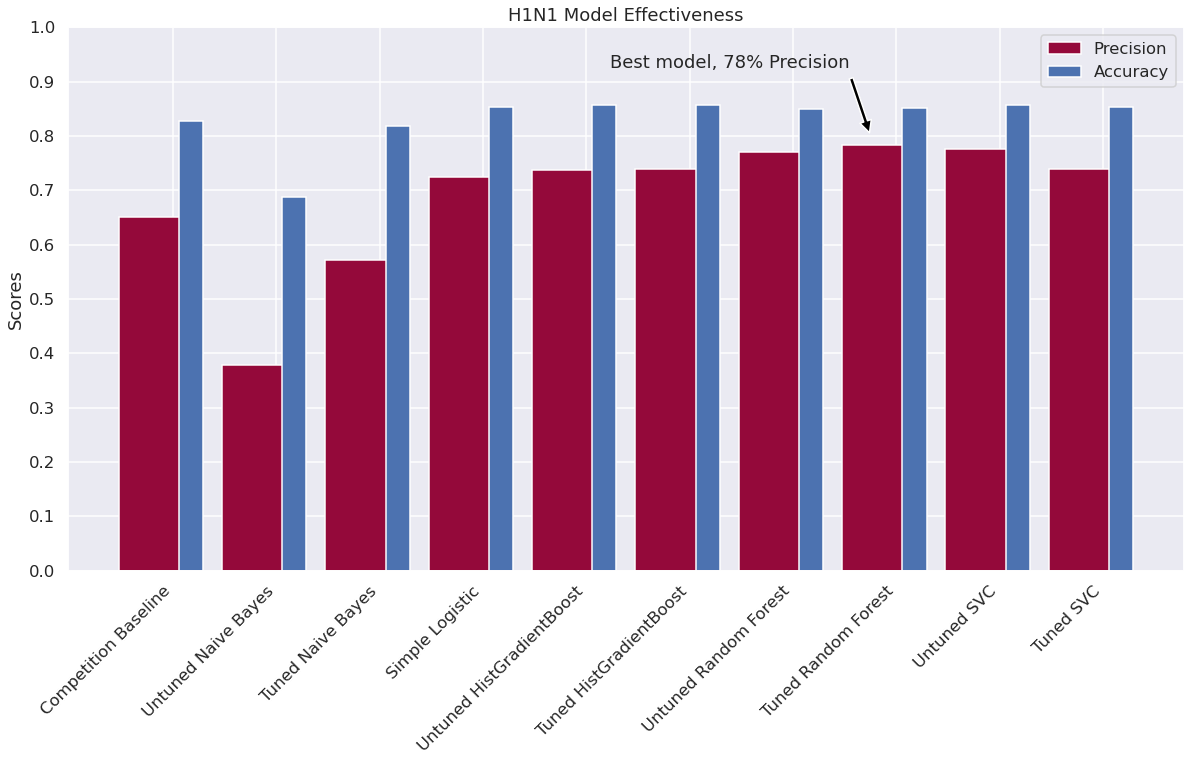

In [263]:
sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(h1n1_xticklabels))) - width/2, h1n1_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(h1n1_xticklabels))) + width/2, h1n1_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(h1n1_xticklabels))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('H1N1 Model Effectiveness')
ax.annotate('Best model, 78% Precision', xy=(6.75, .8),
            xytext=(0.7, .95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top'
            );
#fig.savefig('graphs/H1N1_models', dpi=300, transparent=True, bbox_inches='tight', pad_inches=1);

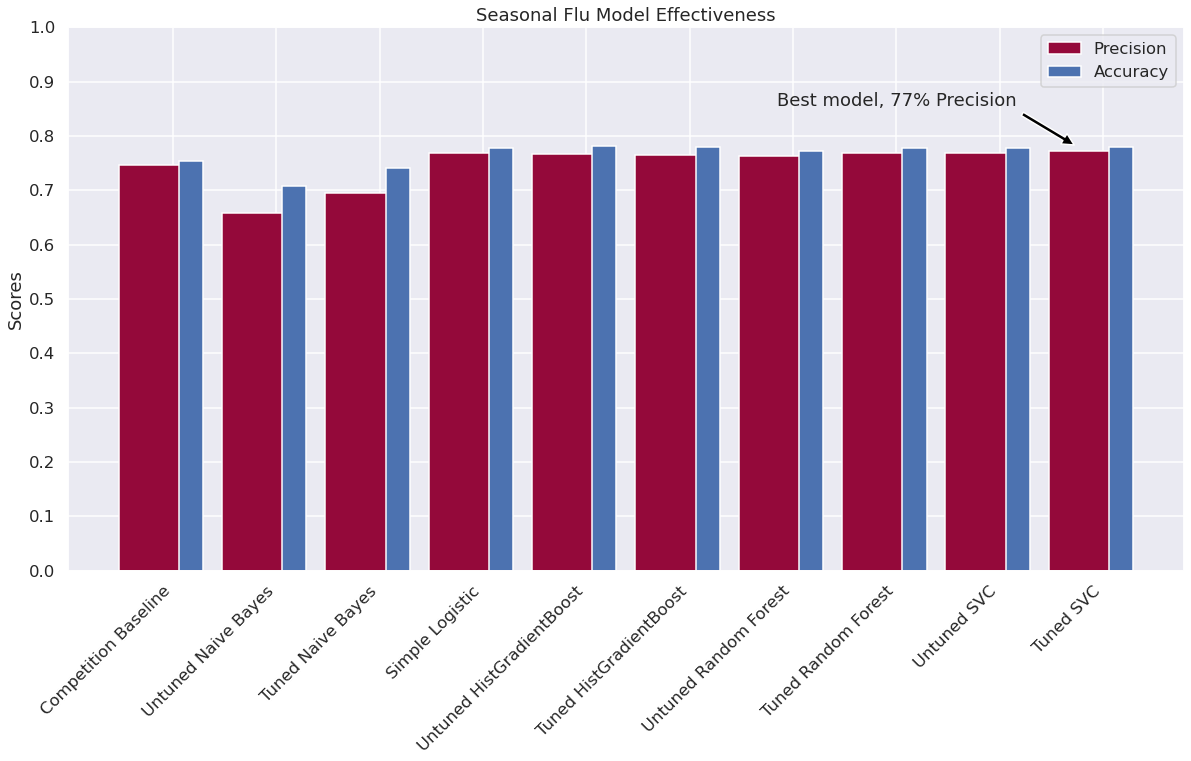

In [265]:
sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(ssnl_xticklabels))) - width/2, ssnl_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(ssnl_xticklabels))) + width/2, ssnl_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(ssnl_xticklabels))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('Seasonal Flu Model Effectiveness')
ax.annotate('Best model, 77% Precision', xy=(8.75, .78),
            xytext=(0.85, .88), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top'
            );
#fig.savefig('graphs/SSNL_models', dpi=300, transparent=False, bbox_inches='tight', pad_inches=1);